<a href="https://colab.research.google.com/github/emmanuel-olateju/elbow_MI/blob/strokeMI%2FLiu2024/bci_processing_elbowMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Pre-defs & Pre-loads

In [1]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
from IPython import display
from IPython.display import clear_output
import time
import logging
import warnings

logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

import os
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# ! pip3 install torchmetrics
! pip3 install mne
# ! pip3 install pyEDFlib
time.sleep(0.25)
clear_output()

In [5]:
from tqdm import tqdm
import gc
import joblib
import random
import math

import mne

import numpy as np
import pandas as pd
import scipy.io

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming
import librosa

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import shutil

In [7]:
import yaml

with open("config.yaml") as f:
  config = yaml.safe_load(f)

In [8]:
! mkdir plots
# mat_files = os.listdir(dataset_dir)

dataset_dir = os.path.join(config['DATASET_DIR'], 'edffile.zip')
! unzip $dataset_dir
clear_output()
print("EDFs Unzipped")

EDFs Unzipped


In [9]:
import json

with open('task-motor-imagery_eeg.json') as f:
  eeg_info = json.load(f)

fs = eeg_info['SamplingFrequency']
f_DC = eeg_info['PowerLineFrequency']
REF = eeg_info['EEGReference']
GND = eeg_info['EEGGround']

In [10]:
annotations = pd.read_csv('task-motor-imagery_events.tsv', sep='\t')
annotations = annotations[annotations['value']==2]
annotations = annotations[['onset', 'duration', 'trial_type']].values

for idx in range(annotations.shape[0]):
  annotations[idx, 0:2] = (annotations[idx, 0:2] / 1000) * fs

In [11]:
channels = pd.read_csv('task-motor-imagery_channels.tsv', sep='\t')
channels_idx = chs_idx = list(map(int, channels.index.values))
channel_types = ch_tps = list(channels['type'].values)
channels = chs = list(channels['name'].values)
channels_map = chs_map = dict(zip(channels, channels_idx))

In [ ]:
# choi = channels_of_interest = [13, 17, 28, 30, 32, 43]
# idx_to_ch = {
#     13: "FC3",
#     17: "FC4",
#     28: "C3",
#     30: "Cz",
#     32: "C4",
#     43: "CP3",
# }

# @title STFT Settings
TIME_OFFSET = 0
TIME_WINDOW = 2
fs = 512
N_SAMPLES = int(TIME_WINDOW*512)

T_HOP = int(0.05 * N_SAMPLES) #int(0.0125 * TIME_WINDOW *fs)
WINDOW_SIZE = int(0.1 * N_SAMPLES)
NFFT = 1024
window = hamming(WINDOW_SIZE, sym=True)
STFT = ShortTimeFFT(window, T_HOP, fs=fs, mfft=NFFT, scale_to="psd")

freq_idx = (STFT.f>=8) & (STFT.f<=30)
n_freqs = len(STFT.f[freq_idx])
n_times = int(fs*TIME_WINDOW / T_HOP) + 1
print(n_freqs, n_times)
print(NFFT, T_HOP, N_SAMPLES)

45 21
1024 51 1024


## STFT Feature Computation

In [12]:
subjects = os.listdir('edffile')

In [13]:
# @title Functions

def get_subject_imagery_epochs(subject):
  left_imagery_epochs = []
  right_imagery_epochs = []

  raw = mne.io.read_raw_edf(os.path.join('edffile', subject, 'eeg', f'{subject}_task-motor-imagery_eeg.edf'))
  eeg_data = raw.get_data()

  for annotn in annotations:
    s_idx = annotn[0]
    e_idx = annotn[0] + annotn[1]

    epoch = eeg_data[:, s_idx:e_idx]
    if annotn[2]==1:
      left_imagery_epochs.append(epoch)
    elif annotn[2]==2:
      right_imagery_epochs.append(epoch)

  left_imagery_epochs = np.array(left_imagery_epochs)
  right_imagery_epochs = np.array(right_imagery_epochs)

  return left_imagery_epochs, right_imagery_epochs

def get_all_subjects_imagery_epochs(subjects):
  left_imagery_epochs = None
  right_imagery_epochs = None

  for subject in subjects:
    left_imagery, right_imagery = get_subject_imagery_epochs(subject)

    if left_imagery_epochs is None:
      left_imagery_epochs = left_imagery
    else:
      left_imagery_epochs = np.concatenate((left_imagery_epochs, left_imagery), axis=0)

    if right_imagery_epochs is None:
      right_imagery_epochs = right_imagery
    else:
      right_imagery_epochs = np.concatenate((right_imagery_epochs, right_imagery), axis=0)

    clear_output()

  return left_imagery_epochs, right_imagery_epochs

def preprocess_epochs(subject_epochs, preprocessing_pipeline=None):
  subject_epochs = mne.filter.filter_data(subject_epochs, sfreq=fs, l_freq=0.5, h_freq=40)

  if preprocessing_pipeline is None:
    return subject_epochs
  else:
    pass

In [14]:
left_imagery, right_imagery = get_all_subjects_imagery_epochs(subjects)

left_imagery = preprocess_epochs(left_imagery)
right_imagery = preprocess_epochs(right_imagery)

left_imagery = left_imagery[::2]
right_imagery = right_imagery[::2]

time.sleep(0.25)
clear_output()

In [15]:
assert left_imagery.shape == right_imagery.shape
N = left_imagery.shape[-1]
left_imagery.shape, right_imagery.shape

((500, 33, 2000), (500, 33, 2000))

In [16]:
left_imagery = left_imagery - left_imagery.mean(axis=1, keepdims=True)
right_imagery = right_imagery - right_imagery.mean(axis=1, keepdims=True)

In [17]:
assert left_imagery.shape == right_imagery.shape
N = left_imagery.shape[-1]
left_imagery.shape, right_imagery.shape

((500, 33, 2000), (500, 33, 2000))

In [18]:
# c3 = channels_map['C3']
# c4 = channels_map['C4']
# new_left_imagery = left_imagery[:, c3, :] - left_imagery[:, c4, :]
# new_right_imagery = right_imagery[:, c3, :] - right_imagery[:, c4, :]

In [19]:
# new_left_imagery.shape, new_right_imagery.shape

In [20]:
# @title STFT Computation

from scipy.signal.windows import hann
from scipy.signal import ShortTimeFFT

W = 250
window = hann(W, sym=False)
hop_ = int(0.01*N)
nfft = 2048
f1, f2 = 8, 30

SFT = ShortTimeFFT(window, hop_, fs, mfft=nfft, scale_to='magnitude')
freqs = (SFT.f>=f1) & (SFT.f<=f2)
n_freqs = len(SFT.f[freqs])
n_times = np.ceil((N + W)/hop_).astype(int).item()
print(f"(f, n): {(n_freqs, n_times)}")

left_imagery_stft = []
right_imagery_stft = []

for epoch in tqdm(left_imagery, total=left_imagery.shape[0], desc="Generating Left Imagery STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  epoch_stft = (epoch_stft - epoch_stft.min()) / (epoch_stft.max() - epoch_stft.min())
  left_imagery_stft.append(epoch_stft)
left_imagery_stft = np.array(left_imagery_stft)

for epoch in tqdm(right_imagery, total=right_imagery.shape[0], desc="Generating Right Imagery STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  right_imagery_stft.append(epoch_stft)
right_imagery_stft = np.array(right_imagery_stft)

left_imagery_stft.shape, right_imagery_stft.shape

(f, n): (90, 113)


Generating Right Imagery STFTs: 100%|██████████| 500/500 [01:20<00:00,  6.20it/s]


((500, 33, 90, 113), (500, 33, 90, 113))

## STFT-CNN Classification

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# @title Training Helpers

class LRScheduler:

    def __init__(self, lr, patience, factor=0.7, margin=0.1, n_evals=100):
        self.lr0 = lr
        self.lr = lr
        self.patience = patience
        self.factor = factor
        self.steps =1
        self.counts = 0
        self.best_metric = float("inf")
        self.margin = margin
        self.n_evals = n_evals

    def exponential_lr(self, metric):
        if metric - self.best_metric > self.margin:
            self.counts += 1
            if self.counts >= self.patience:
                self.best_metric = metric
                self.counts = 0
                self.steps += 1
                self.lr = self.lr0*math.exp(-1*self.factor*self.steps)
                if self.lr < 3E-8:
                    self.lr = 3E-8
        elif metric + self.margin < self.best_metric:
            self.best_metric = metric
            self.counts = 0
        return self.lr


class EarlyStopping:

    def __init__(self, patience, margin=0.1):
        self.patience = patience
        self.margin = margin
        self.steps = 0

    def check(self, train_metric, val_metric):
        if abs(train_metric - val_metric) > self.margin:
            self.steps += 1
        else:
            self.steps = 0

        if self.steps >= self.patience:
            return True
        else:
            return False

class CheckpointModel:

    def __init__(self, margin):
        self.margin = margin
        self.best_metric = float("inf")
        self.best_state = None

    def checkpoint(self, metric, model, message=f"Checkpint Model @ Loss"):
        if metric + self.margin < self.best_metric:
            self.best_metric = metric
            self.best_state = model.state_dict()
            if message!=None:
              print(message)

def init_weights_kaiming_normal(self):
  for m in self.modules():
    if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight, 1)
      nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, 0, 0.01)
      nn.init.constant_(m.bias, 0)

def accuracy_score(logits, classes):
    probs = F.softmax(logits, dim=-1)
    pred = torch.argmax(probs, dim=-1)
    acc = (pred == classes)
    acc  = acc.sum()/len(acc)
    return acc

def binary_acc(y_pred, y_test):
    # y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag = torch.where(y_pred >= 0.5, 1, 0)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [23]:
# @title Dataset Class & Augmentation Class

from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from einops import rearrange

class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, x):
    for t in self.transforms:
      x = t(x)
    return x

class Masking:
  '''
  Augmentation for EEG spectrograms: masking channels, time, and frequency.
  '''
  def __init__(self, channel_dropout_prob=0.1, time_mask_width=4, freq_mask_width=4):
    self.channel_dropout_prob = channel_dropout_prob
    self.time_mask_width = time_mask_width
    self.freq_mask_width = freq_mask_width

  def __call__(self, x):
    F, T = x.size()

    # # --- Channel Dropout ---
    # if random.random() < self.channel_dropout_prob:
    #   num_drop = max(1, int(C * self.channel_dropout_prob))
    #   drop_indices = random.sample(range(C), num_drop)
    #   x[:, :, drop_indices] = 0

    # --- Time Masking ---
    if T > self.time_mask_width:
      t0 = random.randint(0, T - self.time_mask_width)
      x[:, t0:t0+self.time_mask_width] = 0

    # --- Frequency Masking ---
    if F > self.freq_mask_width:
      f0 = random.randint(0, F - self.freq_mask_width)
      x[f0:f0+self.freq_mask_width, :] = 0

    return x

class TimeShifting:
    '''
    Augmentation for EEG spectrograms: shifts the time dimension by a random amount.
    '''
    def __init__(self, max_shift_ratio=0.2):
        """
        Parameters:
        max_shift_ratio (float): Maximum amount to shift as a ratio of the total time dimension
                                 (e.g., 0.2 means shift up to 20% of the time axis)
        """
        self.max_shift_ratio = max_shift_ratio

    def __call__(self, x):
        F, T = x.size()

        # Calculate the maximum shift in time steps
        max_shift = int(T * self.max_shift_ratio)
        if max_shift < 1:
            return x

        # Generate a random shift amount (-max_shift to max_shift)
        shift_amount = random.randint(-max_shift, max_shift)

        # Create a shifted version using roll
        shifted_x = torch.roll(x, shifts=shift_amount, dims=1)

        # If shifting right, zero out the beginning
        if shift_amount > 0:
            shifted_x[:, :shift_amount] = 0
        # If shifting left, zero out the end
        elif shift_amount < 0:
            shifted_x[:, shift_amount:] = 0

        return shifted_x


class NoiseAugmentation:
    '''
    Augmentation for EEG spectrograms: adds different types of noise.
    '''
    def __init__(self, noise_types=['gaussian', 'saltpepper'],
                 gaussian_std_range=(0.01, 0.05),
                 saltpepper_prob_range=(0.01, 0.05),
                 saltpepper_intensity_range=(0.2, 1.0)):
        """
        Parameters:
        noise_types (list): Types of noise to potentially apply ('gaussian', 'saltpepper')
        gaussian_std_range (tuple): Range for standard deviation for Gaussian noise
        saltpepper_prob_range (tuple): Range for probability of salt and pepper noise
        saltpepper_intensity_range (tuple): Range for intensity of salt and pepper noise
        """
        self.noise_types = noise_types
        self.gaussian_std_range = gaussian_std_range
        self.saltpepper_prob_range = saltpepper_prob_range
        self.saltpepper_intensity_range = saltpepper_intensity_range

    def __call__(self, x):
        # Choose one noise type randomly
        noise_type = random.choice(self.noise_types)

        if noise_type == 'gaussian':
            return self._add_gaussian_noise(x)
        elif noise_type == 'saltpepper':
            return self._add_saltpepper_noise(x)
        return x

    def _add_gaussian_noise(self, x):
        std = random.uniform(*self.gaussian_std_range)
        noise = torch.randn_like(x) * std
        return torch.clamp(x + noise, 0.0, 1.0)  # Assuming data is normalized to [0, 1]

    def _add_saltpepper_noise(self, x):
        prob = random.uniform(*self.saltpepper_prob_range)
        intensity = random.uniform(*self.saltpepper_intensity_range)

        # Create a mask for the noise positions
        mask = torch.rand_like(x) < prob

        # Create salt (high value) and pepper (low value) masks
        salt = mask & (torch.rand_like(x) < 0.5)
        pepper = mask & ~salt

        # Apply salt and pepper noise
        result = x.clone()
        result[salt] = torch.clamp(result[salt] + intensity, 0.0, 1.0)
        result[pepper] = torch.clamp(result[pepper] - intensity, 0.0, 1.0)

        return result

# from fancyPCA import *
# class FancyPCA:

#   def __init__(self, alpha):
#     self.alpha = alpha

#   def __call__(self, x):
#     res = batch_fpca(x, self.alpha)
#     return res

class elbowMIDataset(Dataset):

  def __init__(self, X, y=None, transform=None, augment_prob=0.3):
    super(elbowMIDataset, self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    if y is not None:
      self.y = torch.tensor(y, dtype=torch.long)
    else:
      self.y = None
    self.transform = transform
    self.transform_p = augment_prob

  def __len__(self):
    if self.y is not None:
      assert len(self.X) == len(self.y)
    return self.X.size(0)

  def __getitem__(self, idx):
    x = self.X[idx,::]
    if (self.transform is not None) and (random.random()<self.transform_p):
      x = self.transform(x)
    if self.y is not None:
      return x, self.y[idx]
    return x

#### Dataset & DataLoader

In [24]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

def stratified_split(X, y, test_size=0.2):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  train_idx, test_idx = next(sss.split(X, y))

  return (X[train_idx, ::], y[train_idx]), (X[test_idx, ::], y[test_idx])

def make_channel_image(X, ch):
  B, C, _, _ = X.shape
  X_img = np.empty((B, C, 224, 224))

  for ch_idx in range(X.shape[1]):
    for s_idx in range(X.shape[0]):

      arr = X[s_idx, ch_idx, ::]
      arr = cv2.normalize(arr, None, 0, 255, cv2.NORM_MINMAX)
      arr = arr.astype(np.uint8)
      arr = cv2.resize(arr, (224, 224), interpolation=cv2.INTER_LINEAR)
      arr = arr.reshape((1, 224, 224))
      X_img[s_idx, ch_idx, ::] = arr

  return X_img

from fancyPCA import *
def FancyPCA_Augmentation(X, y, alpha, ratio):
  N = int(ratio*len(X))
  idx = np.random.choice(len(X), N, replace=False)
  x = X[idx, ::]
  y = y[idx]

  x = batch_fpca(x, alpha)
  return x, y

In [25]:
from PIL import Image
import cv2

y = [0]*left_imagery_stft.shape[0] + [1]*right_imagery_stft.shape[0]
y = np.array(y)

fz = channels_map['Fz']
f3 = channels_map['F3']
f4 = channels_map['F4']
fcz = channels_map['FCz']
fc3 = channels_map['FC3']
fc4 = channels_map['FC4']
c3 = channels_map['C3']
c4 = channels_map['C4']
cz = channels_map['Cz']
cp3 = channels_map['CP3']
cp4 = channels_map['CP4']
p3 = channels_map['P3']
p4 = channels_map['P4']
pz = channels_map['Pz']

choi = [c3, c4, cz]


# --> Data Pipeline 1
# temp_c3 = np.vstack((
#     left_imagery_stft[:, c3, :, :] - left_imagery_stft[:, c4, :, :],
#     right_imagery_stft[:, c3, :, :] - right_imagery_stft[:, c4, :, :],
# ))
# temp_c3_c4 = np.expand_dims(temp_c3_c4, axis=1)
# temp_c3_cz = np.vstack((
#     left_imagery_stft[:, c3, :, :] - left_imagery_stft[:, cz, :, :],
#     right_imagery_stft[:, c3, :, :] - right_imagery_stft[:, cz, :, :],
# ))
# temp_c3_cz = np.expand_dims(temp_c3_cz, axis=1)
# temp_c4_cz = np.vstack((
#     left_imagery_stft[:, c4, :, :] - left_imagery_stft[:, cz, :, :],
#     right_imagery_stft[:, c4, :, :] - right_imagery_stft[:, cz, :, :],
# ))
# temp_c4_cz = np.expand_dims(temp_c4_cz, axis=1)
# temp_X = np.concatenate((temp_c3_c4, temp_c3_cz, temp_c4_cz), axis=1)

# --> Data Pipeline 2
temp_X = np.vstack((
    left_imagery_stft[:, [c3, c4, cz], :, :],
    right_imagery_stft[:, [c3, c4, cz], :, :],
))
temp_X = np.log1p(temp_X)

# --> Data Pipeline 3
# temp_X = np.vstack((
#     left_imagery_stft[:, [c3, c4, cz, f3, f4, fz], :, :],
#     right_imagery_stft[:, [c3, c4, cz, f3, f4, fz], :, :],
# ))

(X_train, y_train), (X_test, y_test) = stratified_split(temp_X, y, test_size=0.2)
X_train_fpca, y_train_fpca = FancyPCA_Augmentation(X_train, y_train, alpha=0.1, ratio=0.1)
X_train = np.concatenate((X_train, X_train_fpca), axis=0)
y_train = np.concatenate((y_train, y_train_fpca), axis=0)

temp_X = None
print(f"Train Size-> X:{X_train.shape}, y:{y_train.shape}")
print(f"Test Size-> X:{X_test.shape}, y:{y_test.shape}")

Train Size-> X:(880, 3, 90, 113), y:(880,)
Test Size-> X:(200, 3, 90, 113), y:(200,)


In [26]:
# @title Make PyTorch DataLoader

from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import torch
import gc
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

train_batch = 40
test_batch = 10

# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_idx, test_idx = next(gss.split(X, y, groups=IDs))

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_idx, test_idx = next(sss.split(X, y))
# X_train = X[train_idx, ::]
# y_train = y[train_idx]

train = elbowMIDataset(X_train, torch.tensor(y_train).to(torch.float32), transform=None)
test = elbowMIDataset(X_test, torch.tensor(y_test).to(torch.float32))

g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, generator=g)
test_loader = DataLoader(test, batch_size=test_batch, shuffle=False)

#### Models

In [27]:
# @title CNN

import torch.nn.functional as F

class SPEC_CNN(nn.Module):
  def __init__(self):
    super(SPEC_CNN, self).__init__()

    self.in_btn = nn.BatchNorm2d(3)
    self.conv1 = nn.Conv2d(3, 3, kernel_size=(32, 32), stride=(8, 8), padding=(0, 0), bias=False)
    self.relu1 = nn.LeakyReLU(inplace=True)
    self.btn1 = nn.BatchNorm2d(3)
    self.avgpool1 = nn.AdaptiveAvgPool2d((20, 20))

    self.conv2 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0), bias=False)
    self.relu2 = nn.LeakyReLU(inplace=True)
    self.btn2 = nn.BatchNorm2d(1)

    self.fc = nn.Linear(1*20*9, 2)

  def forward(self, x):
    x = self.in_btn(x)
    x = self.conv1(x)
    x = self.btn1(x)
    x = self.relu1(x)
    x = self.avgpool1(x)

    x = self.conv2(x)
    x = self.btn2(x)
    x = self.relu2(x)

    x = rearrange(x, 'b c h w -> b (c h w)')
    logits = self.fc(x)
    return logits

class SPEC_CNN_1(nn.Module):
  def __init__(self):
    super(SPEC_CNN_1, self).__init__()

    self.in_btn = nn.BatchNorm2d(3)
    self.conv11 = nn.Conv2d(3, 3, kernel_size=(32, 32), stride=(8, 8), padding=(0, 0), bias=False)
    self.relu11 = nn.LeakyReLU(inplace=True)
    self.btn11 = nn.BatchNorm2d(3)
    self.avgpool11 = nn.AdaptiveAvgPool2d((20, 20))

    self.conv12 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0), bias=False)
    self.relu12 = nn.LeakyReLU(inplace=True)
    self.btn12 = nn.BatchNorm2d(1)

    self.conv13 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0), bias=False)
    self.relu13 = nn.LeakyReLU(inplace=True)
    self.btn13 = nn.BatchNorm2d(1)

    self.fc12 = nn.Linear(1*20*9, 2*20*9)
    self.fc13 = nn.Linear(1*20*9, 2*20*9)

    self.fc_dropout = nn.Dropout(p=0.7)
    self.fc = nn.Linear(4*20*9, 2)

  def forward(self, x):
    x = self.in_btn(x)
    x = self.conv11(x)
    x = self.btn11(x)
    x = self.relu11(x)
    x = self.avgpool11(x)

    x12 = self.conv12(x)
    x12 = self.btn12(x12)
    x12 = self.relu12(x12)

    x13 = rearrange(x, 'b c h w -> b c w h')
    x13 = self.conv13(x13)
    x13 = self.btn13(x13)
    x13 = self.relu13(x13)
    x13 = x13

    x = torch.cat((x12, x13), dim=1)
    x = rearrange(x, 'b c h w -> b (c h w)')
    x = F.dropout(x, p=0.8)
    logits = self.fc(x)

class SPEC_CNN_2(nn.Module):
  def __init__(self):
    super(SPEC_CNN_2, self).__init__()

    self.in_btn = nn.BatchNorm2d(3)
    self.conv11 = nn.Conv2d(3, 3, kernel_size=(32, 32), stride=(8, 8), padding=(0, 0), bias=False)
    self.relu11 = nn.LeakyReLU(inplace=True)
    self.btn11 = nn.BatchNorm2d(3)
    self.avgpool11 = nn.AdaptiveAvgPool2d((20, 20))

    self.conv12 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0), bias=False)
    self.relu12 = nn.LeakyReLU(inplace=True)
    self.btn12 = nn.BatchNorm2d(1)

    self.conv13 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0), bias=False)
    self.relu13 = nn.LeakyReLU(inplace=True)
    self.btn13 = nn.BatchNorm2d(1)

    self.fc12 = nn.Linear(1*20*9, 2*20*9)
    self.fc13 = nn.Linear(1*20*9, 2*20*9)

    self.fc_dropout = nn.Dropout(p=0.7)
    self.fc = nn.Linear(4*20*9, 2)

  def forward(self, x):
    x = self.in_btn(x)
    x = self.conv11(x)
    x = self.btn11(x)
    x = self.relu11(x)
    x = self.avgpool11(x)

    x12 = self.conv12(x)
    x12 = self.btn12(x12)
    x12 = self.relu12(x12)

    x13 = rearrange(x, 'b c h w -> b c w h')
    x13 = self.conv13(x13)
    x13 = self.btn13(x13)
    x13 = self.relu13(x13)
    x13 = x13

    x12 = rearrange(x12, 'b c h w -> b (c h w)')
    x13 = rearrange(x13, 'b c h w -> b (c h w)')
    x12 = F.leaky_relu(self.fc12(x12))
    x13 = F.leaky_relu(self.fc13(x13))

    x = torch.cat((x12, x13), dim=1)
    x = self.fc_dropout(x)
    logits = self.fc(x)
    return logits

In [28]:
# @title Model Forward-Eval

def run(model, x, y=None, transforms=None, LBL_SMOOTH=0.0):
  if transforms is not None:
    x = transforms(x)

  logits = model(x)
  if y is not None:
    # y = y.unsqueeze(1)
    # y = y.to(torch.float)
    loss = F.cross_entropy(logits, y, label_smoothing=LBL_SMOOTH)
    acc = accuracy_score(logits, y)
    return logits, loss, acc
  return logits

### Movement-Movement (Execution) Classification

In [29]:
# np.random.seed(42)
# torch.use_deterministic_algorithms(False)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# model = resnet18

model = SPEC_CNN_2()
init_weights_kaiming_normal(model)

In [30]:
# example = torch.randint(0, 255, size=(5, 3, 224, 224)).to(torch.float32)
# res = model(example)
# res.size()
model

SPEC_CNN_2(
  (in_btn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv11): Conv2d(3, 3, kernel_size=(32, 32), stride=(8, 8), bias=False)
  (relu11): LeakyReLU(negative_slope=0.01, inplace=True)
  (btn11): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool11): AdaptiveAvgPool2d(output_size=(20, 20))
  (conv12): Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), bias=False)
  (relu12): LeakyReLU(negative_slope=0.01, inplace=True)
  (btn12): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv13): Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 2), bias=False)
  (relu13): LeakyReLU(negative_slope=0.01, inplace=True)
  (btn13): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=180, out_features=360, bias=True)
  (fc13): Linear(in_features=180, out_features=360, bias=True)
  (fc_dropout): Dropout(p=0.7, inplace=False)
  (fc): Lin

In [ ]:
# @title Network weights and gradients

plt.figure(figsize=(12, 5))

    # Create two subplots
ax1 = plt.subplot(1, 2, 1)  # For weights
ax2 = plt.subplot(1, 2, 2)  # For gradients

# Define colors for layers
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, (name, param) in enumerate(model.named_parameters()):

  # if name == "fc_final.weight":
  #   continue

  if 'weight' in name:
      color = colors[i % len(colors)]  # Cycle through colors

      if ("batch" in name):
        continue
      if ("fc" in name):
        continue

      # Plot weight distribution
      ax1.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)

      # Plot gradient distribution (if available)
      # if param.grad is not None:
      #     ax2.hist(param.grad.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)
      # print(
      #     name,
      #     (param.data.cpu().numpy().flatten().min(), param.data.cpu().numpy().flatten().max()), "gradient",
      #     (param.grad.cpu().numpy().flatten().min(), param.grad.cpu().numpy().flatten().max())
      # )

# Configure weight subplot
ax1.set_title('Weight Distributions')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Configure gradient subplot
ax2.set_title('Gradient Distributions')
ax2.set_xlabel('Gradient Value')
ax2.set_ylabel('Frequency')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [31]:
# @title Train

from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

n_iter = 4000
eval_inter = 10
n_evals = int(X_train.shape[0] / train_batch)

history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_precision": [],
    "test_precision": [],
    "iter": [],
    "lr": []
}

lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_, momentum=momentum_, weight_decay=0.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=betas_, weight_decay=0.0)
# lr_scheduler = LRScheduler(lr_, patience=10, factor=0.9, margin=1E-4, n_evals=10)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, threshold=1E-4, min_lr=7E-4, verbose=False)
moment_scheduler = LRScheduler(momentum_, patience=2, factor=0.3, margin=0.01, n_evals=10)

chkpt = CheckpointModel(0.1)
LBL_SMOOTH = 0.0
l1_lambda = 1E-5

model.to(device)

for i in tqdm(range(n_iter), desc="Training", total=n_iter):

  model.train()
  train_loss = 0
  train_acc = 0
  train_precision = 0
  for j, (x, y) in enumerate(train_loader):
    if j>= n_evals:
      break
    x, y = x.to(device), y.to(device)
    # print(f"Train: {torch.unique(y)}")
    optimizer.zero_grad()
    logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)

    # l1_penalty = sum(p.abs().sum() for p in model.parameters())
    # loss = loss + l1_lambda*l1_penalty

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
    optimizer.step()

    # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
    pred = torch.softmax(logits, dim=-1)
    pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    y_bin = label_binarize(y, classes=range(2))
    if np.isnan(pred).sum() >0:
      print(logits)
    train_precision += average_precision_score(y_bin, pred, average="micro")
    train_loss += loss.item()
    train_acc += acc.item()

  train_precision /= n_evals
  train_loss /= n_evals
  train_acc /= n_evals

  if i==0 or i%eval_inter==0 or i==n_iter-1:
    model.eval()
    test_loss = 0
    test_acc = 0
    test_precision = 0
    with torch.no_grad():
      for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        # print(f"Test: {torch.unique(y)}")
        logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)

        # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
        pred = torch.softmax(logits, dim=-1)
        pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        y_bin = label_binarize(y, classes=range(2))
        test_precision += average_precision_score(y_bin, pred, average="micro")
        test_loss += loss.item()
        test_acc += acc.item()

    test_precision /= len(test_loader)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    history["train_precision"].append(train_precision)
    history["test_precision"].append(test_precision)
    history["iter"].append(i)
    history["lr"].append(lr_)

    # print(f"TrainAcc={train_acc:.2f}, TestAcc = {test_acc:.2f}, TrainLoss={train_loss:.4f}, TestLoss={test_loss:.4f}, lr, moment=({lr_:.2E},{momentum_:.2E})")
    chkpt.checkpoint(test_loss, model, f"Checkpoint @{i+1}/{n_iter}: testLoss:{test_loss:.4f}, testAcc:{test_acc:.2f}")

    # lr_ = lr_scheduler.exponential_lr(test_loss)
    # for param_group in optimizer.param_groups:
    #   param_group["lr"] = lr_

    # lr_scheduler.step(test_loss)
    # lr_ = lr_scheduler.get_last_lr()[0]

    # momentum_ = moment_scheduler.exponential_lr(test_loss)
    # for param_group in optimizer.param_groups:
    #     param_group['momentum'] = momentum_

Training:   0%|          | 1/4000 [00:01<1:59:13,  1.79s/it]

Checkpoint @1/4000: testLoss:0.6931, testAcc:0.44


Training:   1%|          | 42/4000 [00:09<11:22,  5.80it/s]

Checkpoint @41/4000: testLoss:0.5902, testAcc:0.96


Training:   3%|▎         | 102/4000 [00:19<11:02,  5.88it/s]

Checkpoint @101/4000: testLoss:0.4814, testAcc:0.97


Training:   5%|▍         | 192/4000 [00:35<11:08,  5.70it/s]

Checkpoint @191/4000: testLoss:0.3771, testAcc:0.98


Training:   9%|▊         | 342/4000 [01:01<10:40,  5.71it/s]

Checkpoint @341/4000: testLoss:0.2748, testAcc:0.99


Training:  17%|█▋        | 662/4000 [01:57<09:28,  5.87it/s]

Checkpoint @661/4000: testLoss:0.1681, testAcc:1.00


Training:  53%|█████▎    | 2102/4000 [06:08<06:32,  4.84it/s]

Checkpoint @2101/4000: testLoss:0.0679, testAcc:0.99


Training: 100%|██████████| 4000/4000 [11:40<00:00,  5.71it/s]


In [32]:
(min(history["train_loss"]), max(history["train_loss"])), (min(history["test_loss"]), max(history["test_loss"]))

((0.03567480024966327, 0.6947314143180847),
 (0.042837699456140396, 0.693081921339035))

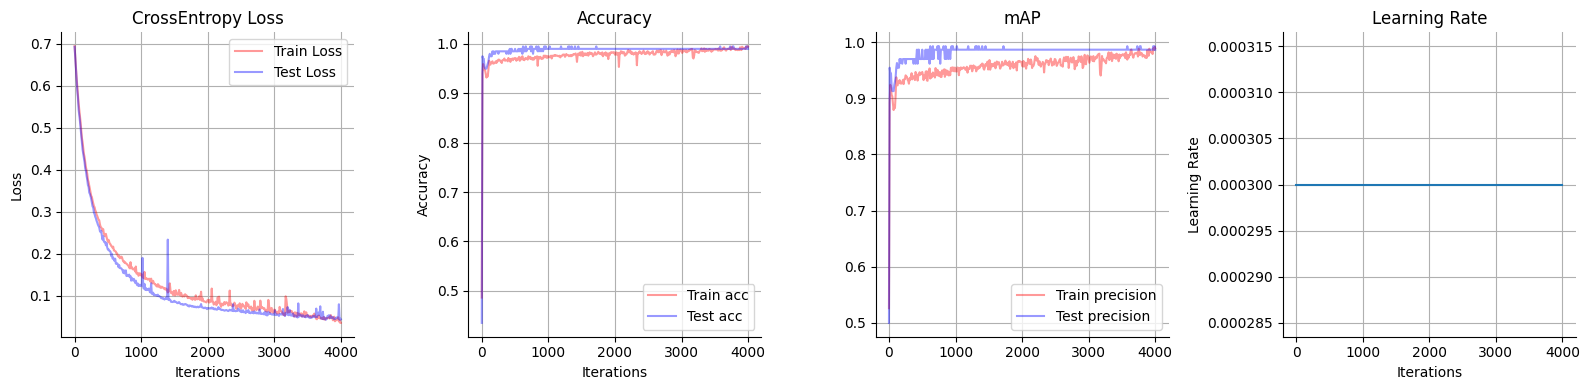

In [33]:
# @title Expt 1 Plot - View Performance Curve

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

m_avg = lambda arr, perc: np.convolve(arr, np.ones(int(len(arr) * perc)) / int(len(arr) * perc), mode='valid')
window = 0.3

# Ensure history has data
if "iter" in history and "train_loss" in history and "test_loss" in history:
    if history["iter"] and history["train_loss"] and history["test_loss"]:  # Check non-empty lists
        # iter_ = m_avg(history["iter"], window)
        iter_ = history["iter"]
        # plt.figure()
        # ax[0].plot(iter_, m_avg(history["train_loss"], window), label="Train Loss", color=(1, 0, 0, 0.7))
        # ax[0].plot(iter_, m_avg(history["test_loss"], window), label="Test Loss", color=(0, 0, 1, 0.7))
        ax[0].plot(iter_, history["train_loss"], label="Train Loss", color=(1, 0, 0, 0.4))
        ax[0].plot(iter_, history["test_loss"], label="Test Loss", color=(0, 0, 1, 0.4))
        ax[0].set_xlabel("Iterations")
        ax[0].set_ylabel("Loss")
        # ax[0].axhline(np.log(n_classes.item()), linestyle="dashed", color="red")
        ax[0].legend()
        ax[0].set_title("CrossEntropy Loss")
        ax[0].spines["top"].set_visible(False)
        ax[0].spines["right"].set_visible(False)
        # ax[0].axhline(0.5, color=(1,0,0,0.8), linestyle="--")
        # ax[0].axhline(0.2, color=(0,0,0,0.8), linestyle="--")
        ax[0].grid()
        # plt.show()

        ax[1].plot(iter_, history["train_acc"], color=(1, 0, 0, 0.4), label="Train acc")
        ax[1].plot(iter_, history["test_acc"], color=(0, 0, 1, 0.4), label="Test acc")
        ax[1].set_xlabel("Iterations")
        ax[1].set_ylabel("Accuracy")
        # ax[1].axhline(0.8, linestyle="dashed", color="red")
        ax[1].legend()
        ax[1].set_title("Accuracy")
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].grid()

        ax[2].plot(iter_, history["train_precision"], color=(1, 0, 0, 0.4), label="Train precision")
        ax[2].plot(iter_, history["test_precision"], color=(0, 0, 1, 0.4), label="Test precision")
        ax[2].legend()
        ax[2].set_title("mAP")
        ax[2].spines["top"].set_visible(False)
        ax[2].spines["right"].set_visible(False)
        ax[2].grid()

        ax[3].plot(iter_, history["lr"], label="Learning Rate")
        ax[3].set_title("Learning Rate")
        ax[3].set_xlabel("Iterations")
        ax[3].set_ylabel("Learning Rate")
        ax[3].spines["top"].set_visible(False)
        ax[3].spines["right"].set_visible(False)
        ax[3].grid()
    else:
        print("History data is empty!")
else:
    print("History keys missing!")

fig.tight_layout()

fig.tight_layout()

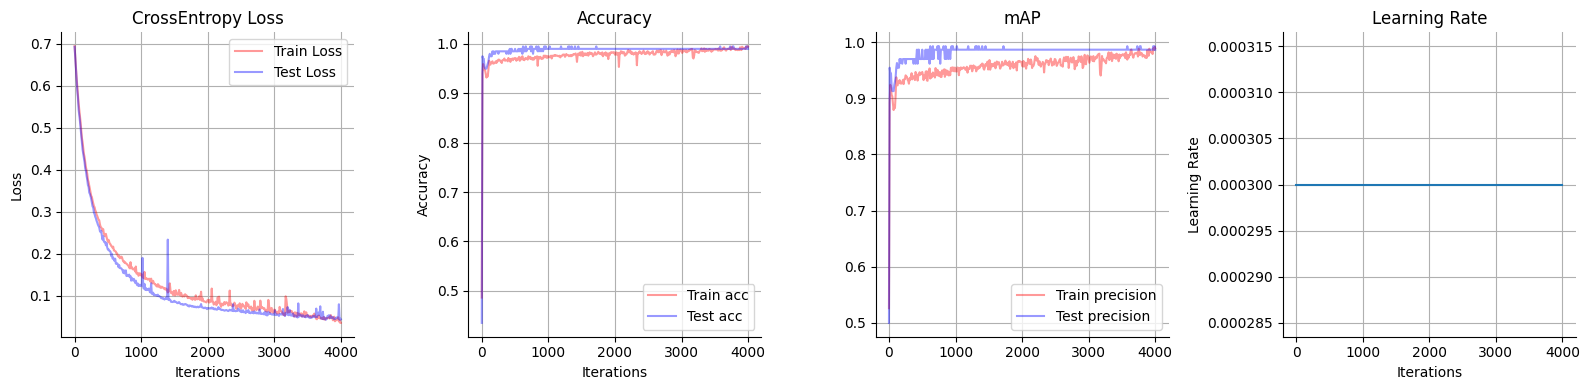

In [38]:
# @title Control Expt Plot - View Performance Curve

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

m_avg = lambda arr, perc: np.convolve(arr, np.ones(int(len(arr) * perc)) / int(len(arr) * perc), mode='valid')
window = 0.3

# Ensure history has data
if "iter" in history and "train_loss" in history and "test_loss" in history:
    if history["iter"] and history["train_loss"] and history["test_loss"]:  # Check non-empty lists
        # iter_ = m_avg(history["iter"], window)
        iter_ = history["iter"]
        # plt.figure()
        # ax[0].plot(iter_, m_avg(history["train_loss"], window), label="Train Loss", color=(1, 0, 0, 0.7))
        # ax[0].plot(iter_, m_avg(history["test_loss"], window), label="Test Loss", color=(0, 0, 1, 0.7))
        ax[0].plot(iter_, history["train_loss"], label="Train Loss", color=(1, 0, 0, 0.4))
        ax[0].plot(iter_, history["test_loss"], label="Test Loss", color=(0, 0, 1, 0.4))
        ax[0].set_xlabel("Iterations")
        ax[0].set_ylabel("Loss")
        # ax[0].axhline(np.log(n_classes.item()), linestyle="dashed", color="red")
        ax[0].legend()
        ax[0].set_title("CrossEntropy Loss")
        ax[0].spines["top"].set_visible(False)
        ax[0].spines["right"].set_visible(False)
        # ax[0].axhline(0.5, color=(1,0,0,0.8), linestyle="--")
        # ax[0].axhline(0.2, color=(0,0,0,0.8), linestyle="--")
        ax[0].grid()
        # plt.show()

        ax[1].plot(iter_, history["train_acc"], color=(1, 0, 0, 0.4), label="Train acc")
        ax[1].plot(iter_, history["test_acc"], color=(0, 0, 1, 0.4), label="Test acc")
        ax[1].set_xlabel("Iterations")
        ax[1].set_ylabel("Accuracy")
        # ax[1].axhline(0.8, linestyle="dashed", color="red")
        ax[1].legend()
        ax[1].set_title("Accuracy")
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].grid()

        ax[2].plot(iter_, history["train_precision"], color=(1, 0, 0, 0.4), label="Train precision")
        ax[2].plot(iter_, history["test_precision"], color=(0, 0, 1, 0.4), label="Test precision")
        ax[2].legend()
        ax[2].set_title("mAP")
        ax[2].spines["top"].set_visible(False)
        ax[2].spines["right"].set_visible(False)
        ax[2].grid()

        ax[3].plot(iter_, history["lr"], label="Learning Rate")
        ax[3].set_title("Learning Rate")
        ax[3].set_xlabel("Iterations")
        ax[3].set_ylabel("Learning Rate")
        ax[3].spines["top"].set_visible(False)
        ax[3].spines["right"].set_visible(False)
        ax[3].grid()
    else:
        print("History data is empty!")
else:
    print("History keys missing!")

fig.tight_layout()

fig.tight_layout()

Text(0.5, 1.0, 'Train Set Confusion Matrix \n (Augmented Samples Inlcuded)')

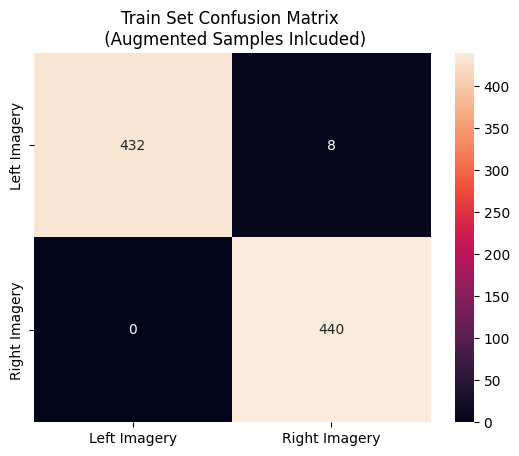

In [34]:
# @title Train-Set Confusion Matrix

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model.load_state_dict(chkpt.best_state)
model.eval()
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        probs = F.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
# cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
sns.heatmap(cm, annot=True, fmt="", yticklabels=["Left Imagery", "Right Imagery"], xticklabels=["Left Imagery", "Right Imagery"])
plt.title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

Text(0.5, 1.0, 'Test Set Confusion Matrix \n (Test Set Does not Have Augmented Samples)')

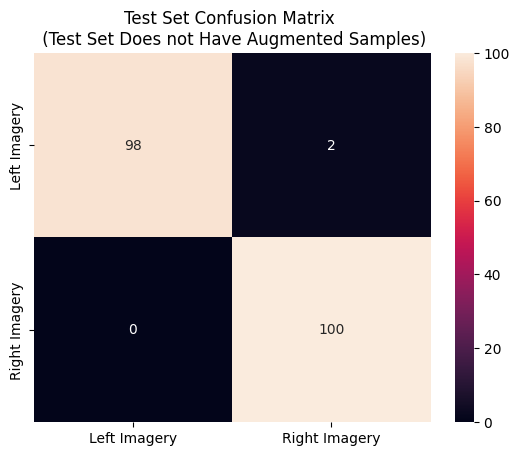

In [35]:
# @title Test-Set Confusion Matrix

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model.load_state_dict(chkpt.best_state)
model.eval()
x, y = test.X, test.y
x = x.to(device)

with torch.no_grad():
  preds = model(x)
  preds = F.softmax(preds, dim=1).cpu().detach()
  preds = torch.argmax(preds, dim=-1)
  # print("Predictions:", preds.argmax(dim=-1))
  # print("Ground Truth:", test.y)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, preds.cpu().numpy())
cm = cm.astype(int)
# cm = cm / cm.sum(axis=1)
sns.heatmap(cm, annot=True, fmt="", yticklabels=["Left Imagery", "Right Imagery"], xticklabels=["Left Imagery", "Right Imagery"])

plt.title("Test Set Confusion Matrix \n (Test Set Does not Have Augmented Samples)")

in_btn.weight
in_btn.weight (np.float32(0.980687), np.float32(1.0124305)) gradient (np.float32(-0.0009612142), np.float32(0.0010812964))
conv11.weight
conv11.weight (np.float32(-0.09858385), np.float32(0.101343475)) gradient (np.float32(-0.0010575328), np.float32(0.0015599628))
btn11.weight
btn11.weight (np.float32(0.88484335), np.float32(1.1254798)) gradient (np.float32(-0.00071054645), np.float32(0.0041496884))
conv12.weight
conv12.weight (np.float32(-0.93497205), np.float32(0.985867)) gradient (np.float32(0.0044483263), np.float32(0.0055254744))
btn12.weight
btn12.weight (np.float32(1.2681191), np.float32(1.2681191)) gradient (np.float32(-0.0027912788), np.float32(-0.0027912788))
conv13.weight
conv13.weight (np.float32(-1.3642856), np.float32(0.9673117)) gradient (np.float32(-0.00011646695), np.float32(-3.7370348e-05))
btn13.weight
btn13.weight (np.float32(1.1901752), np.float32(1.1901752)) gradient (np.float32(-0.00015873836), np.float32(-0.00015873836))


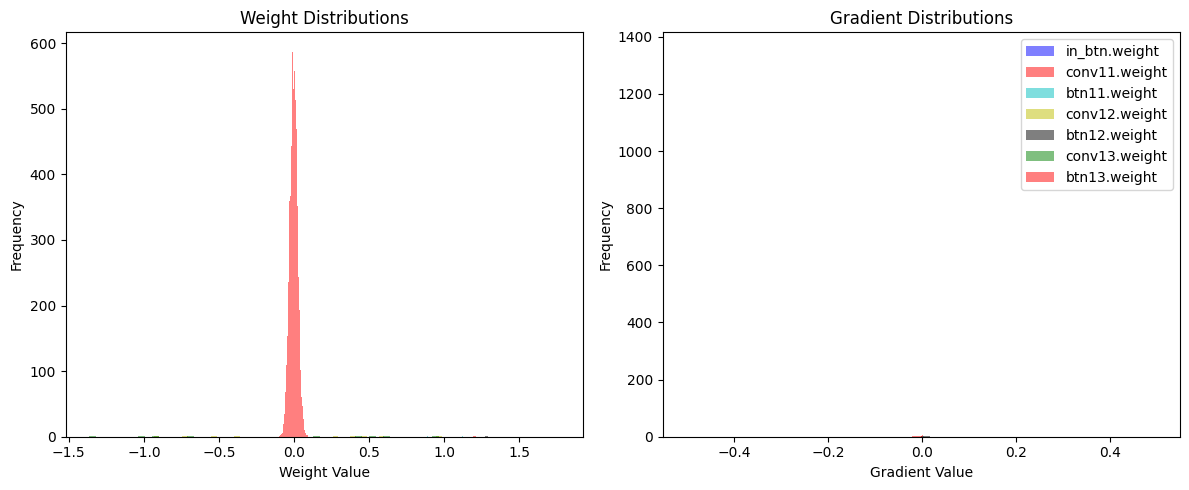

In [36]:
# @title Convolution Layers weights and gradients

plt.figure(figsize=(12, 5))

    # Create two subplots
ax1 = plt.subplot(1, 2, 1)  # For weights
ax2 = plt.subplot(1, 2, 2)  # For gradients

# Define colors for layers
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, (name, param) in enumerate(model.named_parameters()):

  # if name == "fc_final.weight":
  #   continue

  if 'weight' in name:
      color = colors[i % len(colors)]  # Cycle through colors

      if ("batch" in name):
        continue
      if ("fc" in name):
        continue
      print(name)

      # Plot weight distribution
      ax1.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)

      # Plot gradient distribution (if available)
      if param.grad is not None:
          ax2.hist(param.grad.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)
      print(
          name,
          (param.data.cpu().numpy().flatten().min(), param.data.cpu().numpy().flatten().max()), "gradient",
          (param.grad.cpu().numpy().flatten().min(), param.grad.cpu().numpy().flatten().max())
      )

# Configure weight subplot
ax1.set_title('Weight Distributions')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
# ax1.legend()

# Configure gradient subplot
ax2.set_title('Gradient Distributions')
ax2.set_xlabel('Gradient Value')
ax2.set_ylabel('Frequency')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

fc12.weight (np.float32(-0.044180617), np.float32(0.06350314)) gradient (np.float32(-0.0014197577), np.float32(0.00016498966))
fc13.weight (np.float32(-0.04215182), np.float32(0.04732577)) gradient (np.float32(-0.00013055622), np.float32(0.000101940204))
fc.weight (np.float32(-0.10519987), np.float32(0.107255556)) gradient (np.float32(-0.0027918916), np.float32(0.0027918906))


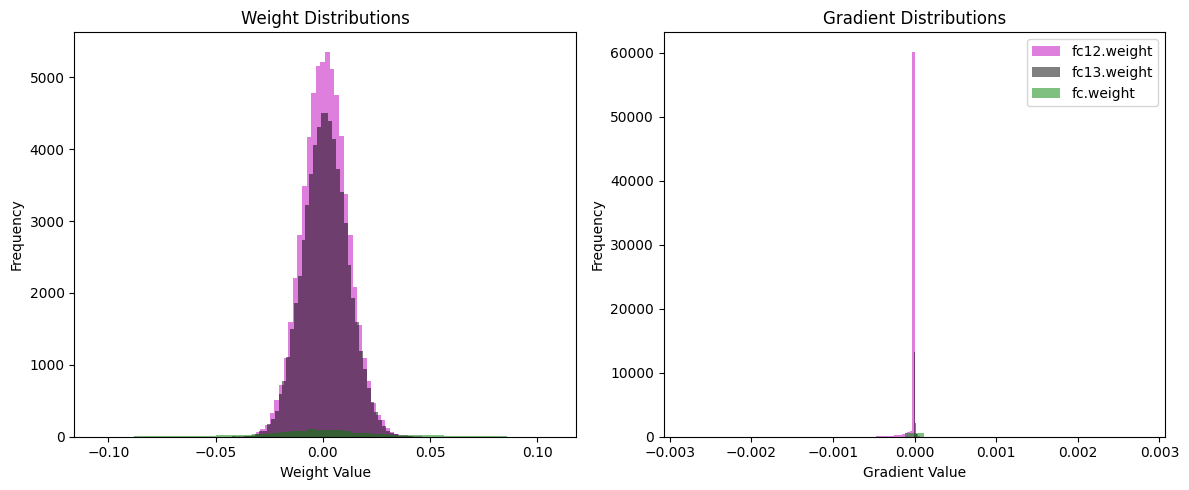

In [37]:
# @title Linear Layers weights and gradients

plt.figure(figsize=(12, 5))

    # Create two subplots
ax1 = plt.subplot(1, 2, 1)  # For weights
ax2 = plt.subplot(1, 2, 2)  # For gradients

# Define colors for layers
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, (name, param) in enumerate(model.named_parameters()):

  # if name == "fc_final.weight":
  #   continue

  if 'weight' in name:
      color = colors[i % len(colors)]  # Cycle through colors

      if ("batch" in name):
        continue
      if ("fc" not in name):
        continue

      # Plot weight distribution
      ax1.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)

      # Plot gradient distribution (if available)
      if param.grad is not None:
          ax2.hist(param.grad.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name, color=color)
      print(
          name,
          (param.data.cpu().numpy().flatten().min(), param.data.cpu().numpy().flatten().max()), "gradient",
          (param.grad.cpu().numpy().flatten().min(), param.grad.cpu().numpy().flatten().max())
      )

# Configure weight subplot
ax1.set_title('Weight Distributions')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
# ax1.legend()

# Configure gradient subplot
ax2.set_title('Gradient Distributions')
ax2.set_xlabel('Gradient Value')
ax2.set_ylabel('Frequency')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## Semantic Representation Learning

### Contrastive Alignment

In [ ]:
# @title Encoder

def nt_xent_loss(logits, labels, temperature=0.5):
  eps = 1E-8

  labels = labels.view(-1, 1)
  target = torch.eq(labels, labels.T).to(torch.float32).to(device)
  target.fill_diagonal_(0)

  B = logits.size(0)
  # logits = logits.reshape(B, -1)
  logits = F.normalize(logits, dim=1)
  sim = (logits @ logits.T)
  sim[torch.eye(B).bool()] = 0

  loss = F.binary_cross_entropy_with_logits(sim/temperature, target, reduction="mean")
  return loss

class SPEC_Encoder(nn.Module):
  def __init__(self, n_freqs=45, n_times=26, n_channels=6, n_classes=6, NGV_SLOPE=0.1, temperature=2):
    super(SPEC_Encoder, self).__init__()
    self.height = n_freqs
    self.width = n_times
    self.ch = n_channels
    self.n_classes = n_classes
    self.NGV_SLOPE = NGV_SLOPE
    self.temperature = temperature

    self.resnet = models.resnet18(pretrained=False)
    self.resnet.conv1 = nn.Conv2d(self.ch*3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    self.conv1 = nn.Conv3d(3, self.n_classes, (2, 8, 8), stride=(1, 4, 4), groups=1)
    self.pool1 = nn.AdaptiveMaxPool3d((5, 40, 40))

    self.conv2 = nn.Conv3d(self.n_classes, self.n_classes, (2, 4, 4), stride=(1, 2, 2), groups=self.n_classes)
    self.pool2 = nn.AdaptiveMaxPool3d((3, 16, 16))

    self.proj = nn.Linear(self.n_classes*3*16*16, 625)

  def forward(self, x, y=None, probe=False):
    B, _, _, _, _ = x.size()
    x = rearrange(x, 'b e h w c -> b c e h w')
    x = x/255
    # x = x.unsqueeze(1)
    # x = self.resnet(x)

    x = F.dropout(x, 0.2)
    x = self.conv1(x)
    x = self.pool1(x)
    x = F.elu(x)

    x = self.conv2(x)
    x = self.pool2(x)
    x = F.elu(x)

    B, K, C, H, W = x.size()
    x = x.reshape(B, -1)
    x = self.proj(x)

    if probe==True:
      return x.reshape(B, -1)
    if y is not None:
      loss = nt_xent_loss(x, y, temperature=self.temperature)
      return x, loss
    return x

In [ ]:
# @title Train

from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

mi_encoder = SPEC_Encoder(n_freqs=45, n_times=22, n_channels=6, n_classes=3, NGV_SLOPE=0.2, temperature=10).to(device)
# mi_encoder.apply(init_weights)

n_iter = 700
eval_inter = 10
n_evals = 6

history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_precision": [],
    "test_precision": [],
    "iter": [],
    "lr": []
}

lr_ = 1E-2
momentum_ = 0.9
betas_ = (0.9, 0.99)
# optimizer = torch.optim.SGD(mi_encoder.parameters(), lr=lr_, momentum=momentum_, weight_decay=0.0)
optimizer = torch.optim.Adam(mi_encoder.parameters(), lr=lr_, betas=betas_, weight_decay=0.0)
lr_scheduler = LRScheduler(lr_, patience=4, factor=0.3, margin=1E-4, n_evals=10)
moment_scheduler = LRScheduler(momentum_, patience=2, factor=0.3, margin=0.01, n_evals=10)

chkpt = CheckpointModel(0)

for i in tqdm(range(n_iter), desc="Training", total=n_iter):

  mi_encoder.train()
  train_loss = 0
  for j, (x, y) in enumerate(train_loader):
    if j>= n_evals:
      break
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = mi_encoder(x, y)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(mi_encoder.parameters(), 1)
    optimizer.step()

    pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
    # pred = torch.softmax(logits, dim=-1)
    # pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    y_bin = label_binarize(y, classes=range(3))
    if np.isnan(pred).sum() >0:
      print(logits)
    train_loss += loss.item()
  train_loss /= n_evals

  if i==0 or i%eval_inter==0 or i==n_iter-1:
    mi_encoder.eval()
    test_loss = 0
    with torch.no_grad():
      for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits, loss = mi_encoder(x, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["iter"].append(i)
    history["lr"].append(lr_)

    print(f"TrainLoss={train_loss:.4f}, TestLoss={test_loss:.4f}, lr, moment=({lr_:.2E},{momentum_:.2E})")
    chkpt.checkpoint(test_loss, mi_encoder, "Checkpoint")

    lr_ = lr_scheduler.exponential_lr(test_loss)
    # momentum_ = moment_scheduler.exponential_lr(test_loss)
    for param_group in optimizer.param_groups:
      param_group["lr"] = lr_
    # for param_group in optimizer.param_groups:
    #     param_group['momentum'] = momentum_

Training:   0%|          | 1/700 [00:02<25:47,  2.21s/it]

TrainLoss=0.7070, TestLoss=0.7035, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   2%|▏         | 11/700 [00:21<24:43,  2.15s/it]

TrainLoss=0.6983, TestLoss=0.6979, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   3%|▎         | 21/700 [00:40<22:08,  1.96s/it]

TrainLoss=0.6943, TestLoss=0.6940, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   4%|▍         | 31/700 [01:00<24:13,  2.17s/it]

TrainLoss=0.6945, TestLoss=0.6946, lr, moment=(1.00E-02,9.00E-01)


Training:   6%|▌         | 41/700 [01:18<21:39,  1.97s/it]

TrainLoss=0.6940, TestLoss=0.6942, lr, moment=(1.00E-02,9.00E-01)


Training:   7%|▋         | 51/700 [01:38<22:31,  2.08s/it]

TrainLoss=0.6936, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   9%|▊         | 61/700 [01:59<23:36,  2.22s/it]

TrainLoss=0.6934, TestLoss=0.6937, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  10%|█         | 71/700 [02:18<22:15,  2.12s/it]

TrainLoss=0.6940, TestLoss=0.6937, lr, moment=(1.00E-02,9.00E-01)


Training:  12%|█▏        | 81/700 [02:38<21:35,  2.09s/it]

TrainLoss=0.6939, TestLoss=0.6936, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  13%|█▎        | 91/700 [03:00<23:29,  2.32s/it]

TrainLoss=0.6937, TestLoss=0.6936, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  14%|█▍        | 101/700 [03:18<19:32,  1.96s/it]

TrainLoss=0.6935, TestLoss=0.6940, lr, moment=(1.00E-02,9.00E-01)


Training:  16%|█▌        | 111/700 [03:38<20:47,  2.12s/it]

TrainLoss=0.6938, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)


Training:  17%|█▋        | 121/700 [03:57<19:19,  2.00s/it]

TrainLoss=0.6942, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  19%|█▊        | 131/700 [04:17<19:51,  2.09s/it]

TrainLoss=0.6936, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  20%|██        | 141/700 [04:36<18:50,  2.02s/it]

TrainLoss=0.6935, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)


Training:  22%|██▏       | 151/700 [04:55<19:26,  2.12s/it]

TrainLoss=0.6937, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)


Training:  23%|██▎       | 161/700 [05:16<20:06,  2.24s/it]

TrainLoss=0.6935, TestLoss=0.6931, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  23%|██▎       | 164/700 [05:22<17:35,  1.97s/it]


KeyboardInterrupt: 

In [ ]:
min(history["train_loss"]), min(history["test_loss"])

(0.6757349868615469, 0.6932553052902222)

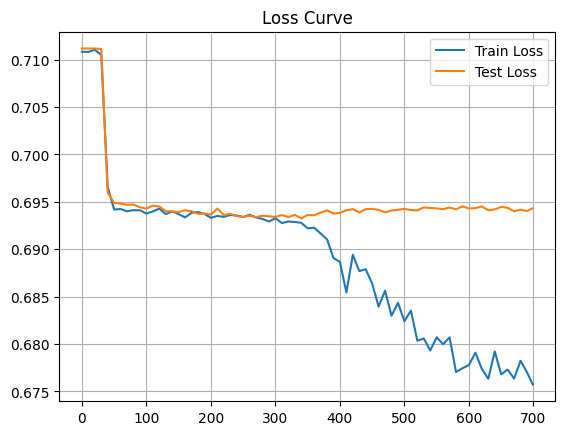

In [ ]:

plt.plot(history["iter"], history["train_loss"], label="Train Loss")
plt.plot(history["iter"], history["test_loss"], label="Test Loss")
plt.grid()
plt.title("Loss Curve")
plt.legend()

torch.Size([80, 1600]) torch.Size([80, 1600]) torch.Size([80, 1600])


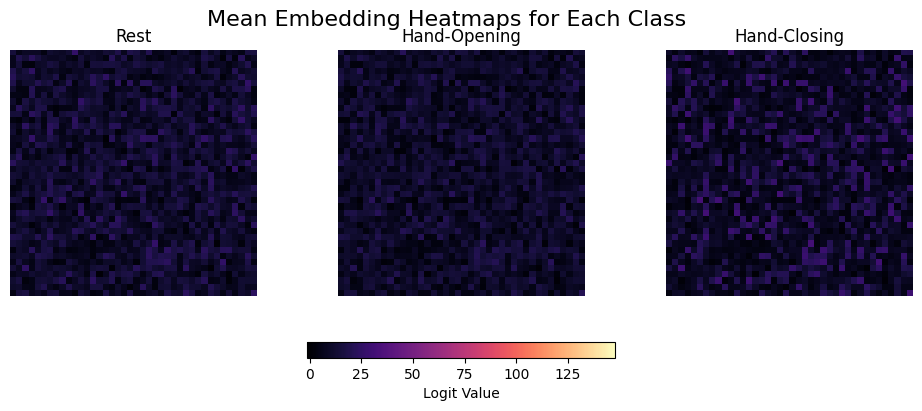

In [ ]:
x_0 = test.X[test.y == 0]
x_1 = test.X[test.y == 1]
x_2 = test.X[test.y == 2]

logits_0 = F.elu(mi_encoder(torch.tensor(x_0).to(device), probe=True))
logits_1 = F.elu(mi_encoder(torch.tensor(x_1).to(device), probe=True))
logits_2 = F.elu(mi_encoder(torch.tensor(x_2).to(device), probe=True))

print(logits_0.size(), logits_1.size(), logits_2.size())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

vmin = min(logits_0.min(), logits_1.min(), logits_2.min()).cpu().item()
vmax = max(logits_0.max(), logits_1.max(), logits_2.max()).cpu().item()

images = []
for e, (embd, label) in enumerate(zip([logits_0, logits_1, logits_2], ["Rest", "Hand-Opening", "Hand-Closing"])):
    embd_ = embd.mean(axis=0).cpu().detach().numpy().reshape(40, 40)
    im = ax[e].imshow(embd_, cmap="magma", vmin=vmin, vmax=vmax)
    ax[e].set_title(label)
    ax[e].axis('off')
    images.append(im)

# Add a single colorbar at the top
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
cbar.set_label("Logit Value")

fig.suptitle("Mean Embedding Heatmaps for Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.1])
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE


# Convert embeddings to numpy for analysis
emb_0 = logits_0.cpu().detach().numpy()
emb_1 = logits_1.cpu().detach().numpy()
emb_2 = logits_2.cpu().detach().numpy()

# 1. Calculate pairwise distances between class means
mean_0 = np.mean(emb_0, axis=0)
mean_1 = np.mean(emb_1, axis=0)
mean_2 = np.mean(emb_2, axis=0)

means = np.vstack([mean_0, mean_1, mean_2])
class_labels = ["Rest", "Hand-Opening", "Hand-Closing"]

dist_matrix = cdist(means, means)
print("\nDistance matrix between class means:")
for i, label_i in enumerate(class_labels):
    for j, label_j in enumerate(class_labels):
        if i < j:  # Only print upper triangle
            print(f"Distance between {label_i} and {label_j}: {dist_matrix[i, j]:.4f}")

# 2. Calculate within-class and between-class variance
all_embeddings = np.vstack([emb_0, emb_1, emb_2])
all_labels = np.hstack([np.zeros(len(emb_0)), np.ones(len(emb_1)), 2*np.ones(len(emb_2))])

# 3. Calculate silhouette score - measure of how well samples are clustered
if len(emb_0) > 1 and len(emb_1) > 1 and len(emb_2) > 1:
    silhouette = silhouette_score(all_embeddings, all_labels)
    print(f"\nSilhouette score: {silhouette:.4f}")
    print("  - Closer to 1 means better separated clusters")
    print("  - Closer to 0 means overlapping clusters")
    print("  - Negative values mean samples are assigned to wrong clusters")

# 4. Visualize with t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']
for i, label in enumerate(["Rest", "Hand-Opening", "Hand-Closing"]):
    idx = all_labels == i
    plt.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        c=colors[i],
        marker=markers[i],
        label=label,
        alpha=0.7
    )
plt.title("t-SNE Visualization of Class Embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("class_embeddings_tsne.png")
plt.close()


Distance matrix between class means:
Distance between Rest and Hand-Opening: 70.6364
Distance between Rest and Hand-Closing: 139.8769
Distance between Hand-Opening and Hand-Closing: 171.3706

Silhouette score: -0.0355
  - Closer to 1 means better separated clusters
  - Closer to 0 means overlapping clusters
  - Negative values mean samples are assigned to wrong clusters


In [ ]:
def compute_class_separability():
    # Overall mean
    global_mean = np.mean(all_embeddings, axis=0)

    # Class means
    means = [mean_0, mean_1, mean_2]

    # Between-class scatter
    between_scatter = np.zeros((means[0].shape[0], means[0].shape[0]))
    for i, mean in enumerate([mean_0, mean_1, mean_2]):
        n_samples = [len(emb_0), len(emb_1), len(emb_2)][i]
        mean_diff = mean - global_mean
        between_scatter += n_samples * np.outer(mean_diff, mean_diff)

    # Within-class scatter
    within_scatter = np.zeros_like(between_scatter)
    for i, emb in enumerate([emb_0, emb_1, emb_2]):
        for sample in emb:
            diff = sample - means[i]
            within_scatter += np.outer(diff, diff)

    # Ensure within_scatter is invertible
    within_scatter += np.eye(within_scatter.shape[0]) * 1e-6

    # Calculate separability ratio (trace-based criterion)
    try:
        inv_within = np.linalg.inv(within_scatter)
        separability = np.trace(np.matmul(inv_within, between_scatter))
        return separability
    except np.linalg.LinAlgError:
        return "Error: Within-class scatter matrix is not invertible"

separability = compute_class_separability()
print(f"\nClass separability measure: {separability}")
print("  - Higher values indicate better class separation")


Class separability measure: -458437.2261522801
  - Higher values indicate better class separation
